In [3]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [4]:
# Analyze reliability, bandwidth, energy
data = []
aliasmap = {"1bpc_bwa_0": "1.1", "1bpc_bwa_1713": "1.2", "1bpc_pba_1291": "1.3", "2bpc_pba_1707": "2.1", "2bpc_bwa_2011": "2.2", "2bpc_bwa_11390": "2.3"}
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    if alias not in aliasmap and alias != "2bpc_bwa_1707":
      continue
    for mode in ["cb", "lfsr"]:
      print(alias, mode)
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
          print("FAIL")
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([np.nan])
          ivddio = np.array([np.nan])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                bad = []
                for i in range(len(postread)-1):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                          if (i + j) % (2**bpc) != postread[i][j]:
                             bad.append([i,j,(i + j) % (2**bpc),postread[i][j]])
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                          if refvec[i][j] != postread[i][j]:
                             bad.append([i,j,refvec[i][j],postread[i][j]])
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                np.savetxt(f"data/confmat/bad_{mode}_{alias}_{att}.csv", bad, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()

        # Fix alias
        if alias == "2bpc_bwa_1707":
          alias = "2bpc_pba_1707"
        
        # Compose dataframe
        d = {"name": f"{aliasmap[alias] if alias in aliasmap else alias} {mode.upper()} ({'PBA' if 'pba' in alias else 'BWA'})", "alias": f"{alias}_{mode}", "mode": mode, "alloc_scheme": "pba" if "pba" in alias else "bwa", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse, "cells": confmat.sum()}
        d.update(diag)
        data.append(d)

        # Revert alias
        if alias == "2bpc_pba_1707":
          alias = "2bpc_bwa_1707"
data = pd.DataFrame(data)
data = data[data["att"] != 3968]
data[data["att"] == 128][["alias","bpc","alloc_scheme","mode","bw","energy_per_bit","cer","ber"]].to_csv("data.csv", index=False)
data

1bpc_bwa_1713 cb
1bpc_bwa_1713 lfsr
1bpc_bwa_0 cb
1bpc_bwa_0 lfsr
1bpc_pba_1291 cb
1bpc_pba_1291 lfsr
2bpc_bwa_1707 cb
2bpc_bwa_1707 lfsr
2bpc_bwa_11390 cb
2bpc_bwa_11390 lfsr
2bpc_bwa_2011 cb
2bpc_bwa_2011 lfsr


,name,alias,mode,alloc_scheme,att,bpc,dt,dt2,power_tot,energy_per_bit,...,cells,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1.2 CB (BWA),1bpc_bwa_1713_cb,cb,bwa,1,1,0.016999006271362305,0.016600,NaN,NaN,...,879956.0,20000,879955,99999,19999,19999,1659976,1320023,439979,439976
1,1.2 CB (BWA),1bpc_bwa_1713_cb,cb,bwa,2,1,0.025361061096191406,0.025001,NaN,NaN,...,879956.0,20000,440008,139997,39998,20028,2500050,2639308,879958,439999
2,1.2 CB (BWA),1bpc_bwa_1713_cb,cb,bwa,4,1,0.03423905372619629,0.034212,NaN,NaN,...,879956.0,20000,439988,180050,79996,20063,3421189,3519763,1759916,440034
3,1.2 CB (BWA),1bpc_bwa_1713_cb,cb,bwa,8,1,0.052777767181396484,0.052621,NaN,NaN,...,879956.0,20000,433499,260088,159992,20104,5262059,5278091,3511688,440078
4,1.2 CB (BWA),1bpc_bwa_1713_cb,cb,bwa,16,1,0.07577347755432129,0.075569,0.005286,4.539887e-10,...,879956.0,20000,15,363339,243174,20181,7556864,7404815,4765026,440154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2.2 LFSR (BWA),2bpc_bwa_2011_lfsr,lfsr,bwa,128,2,0.3992753028869629,0.398926,0.004581,2.076947e-09,...,439956.0,10000,753,1842365,642490,889862,39892554,8851893,2752681,2528473
151,2.2 LFSR (BWA),2bpc_bwa_2011_lfsr,lfsr,bwa,256,2,0.40247607231140137,0.402599,0.004584,2.097183e-09,...,439956.0,10000,13,1859104,645574,901101,40259923,8908702,2750273,2545331
152,2.2 LFSR (BWA),2bpc_bwa_2011_lfsr,lfsr,bwa,512,2,0.4035341739654541,0.403499,0.004610,2.114180e-09,...,439956.0,10000,4,1863065,648303,902189,40349894,8920294,2755653,2552709
153,2.2 LFSR (BWA),2bpc_bwa_2011_lfsr,lfsr,bwa,1024,2,0.40529370307922363,0.405121,0.004608,2.121667e-09,...,439956.0,10000,4,1870293,650738,906473,40512066,8935107,2759838,2554760


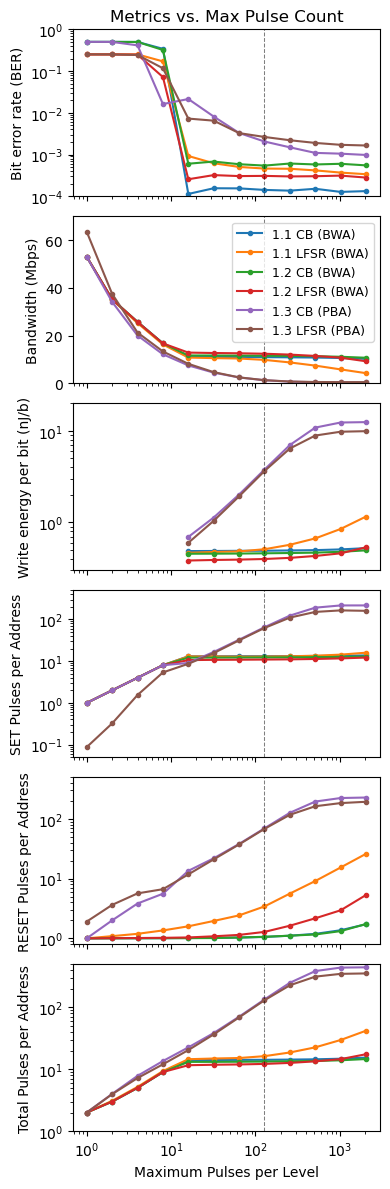

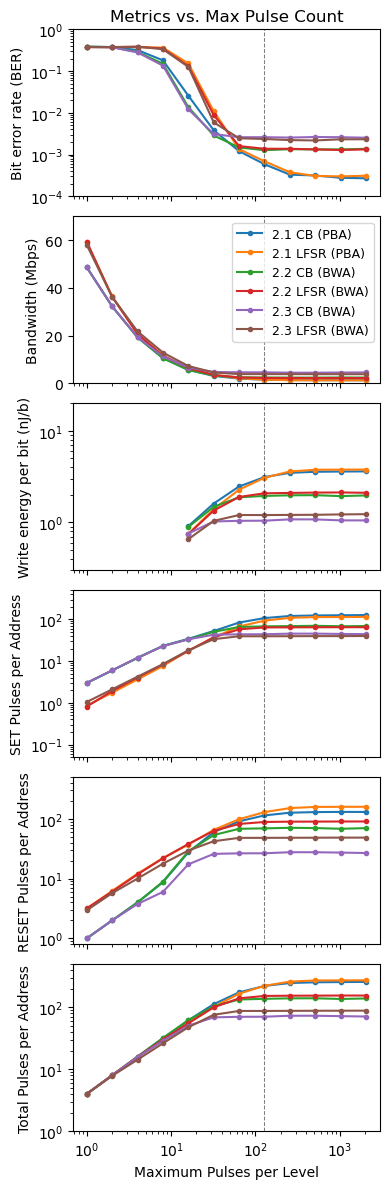

In [5]:
# Plot write BER tradeoff vs. attempts
nplots = 6
for bpc in range(1,3):
  fig, axs = plt.subplots(nplots, 1, figsize=(4,nplots*2), sharex=True)
  for (bpc, alias), d in data[data["bpc"] == bpc].groupby(["bpc", "name"]):
    plt.xlabel("Maximum Pulses per Level")
    plt.xscale("log")
    axs[0].set_title(f"Metrics vs. Max Pulse Count")
    axs[0].set_ylabel("Bit error rate (BER)")
    axs[0].plot(d["att"], d["ber"], ".-", label=alias)
    axs[0].set_ylim(1e-4, 1)

    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
    axs[1].set_ylim(0, 70)

    axs[2].set_ylabel("Write energy per bit (nJ/b)")
    axs[2].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
    axs[2].set_ylim(3e-1, 20)

    axs[3].set_ylabel("SET Pulses per Address")
    axs[3].plot(d["att"], d["sets"]/d["successes"], ".-", label=alias)
    axs[3].set_ylim(5e-2, 500)
    
    axs[4].set_ylabel("RESET Pulses per Address")
    axs[4].plot(d["att"], d["resets"]/d["successes"], ".-", label=alias)
    axs[4].set_ylim(8e-1, 500)

    axs[5].set_ylabel("Total Pulses per Address")
    axs[5].plot(d["att"], (d["sets"] + d["resets"])/d["successes"], ".-", label=alias)
    axs[5].set_ylim(1, 500)

    # axs[6].set_ylabel("SET Pulses per Cell")
    # axs[6].plot(d["att"], d["set_bits"]/d["cells"], ".-", label=alias)

    # axs[7].set_ylabel("RESET Pulses per Cell")
    # axs[7].plot(d["att"], d["reset_bits"]/d["cells"], ".-", label=alias)

    # axs[8].set_ylabel("Total Pulses per Cell")
    # axs[8].plot(d["att"], (d["set_bits"] + d["reset_bits"])/d["cells"], ".-", label=alias)
  for i in range(nplots):
    if i != 1:
      axs[i].set_yscale("log")
    axs[i].axvline(128, color="black", linestyle="--", linewidth=0.75, alpha=0.5)
  axs[1].legend(fontsize=9)
  plt.tight_layout()
  plt.subplots_adjust(hspace=0.12)
  plt.savefig(f"../analysis/figs/{bpc}bpc_metrics.pdf")
  plt.show()

1, cb, y = 4.58x + 0.07, 0.9999759646085445
1, lfsr, y = 4.61x + 0.04, 0.9999731944323174


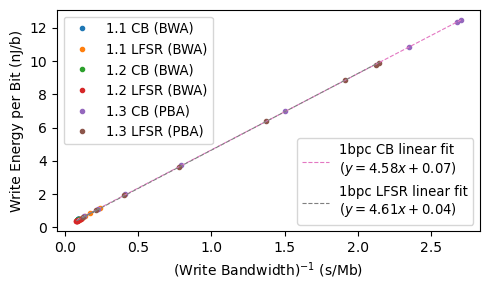

2, cb, y = 4.56x + 0.06, 0.9995600971575127
2, lfsr, y = 4.57x + 0.02, 0.9997547800108519


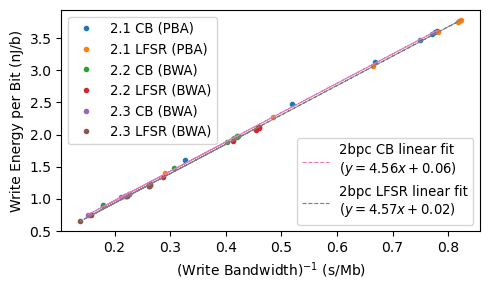

In [6]:
# Plot energy vs. bandwidth to show correlation
for bpc in range(1, 3):
  plt.figure(figsize=(5,3))
  for (bpc, alias), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "name"]):
    plt.xlabel("(Write Bandwidth)$^{-1}$ (s/Mb)")
    plt.ylabel("Write Energy per Bit (nJ/b)")
    plt.plot(1e6/d["bw"], 1e9*d["energy_per_bit"], ".", label=alias)
    # plt.plot((d["sets"] + d["resets"])/d["successes"], 1/d["bw"], ".", label=alias)
    # plt.plot((d["sets"] + d["resets"])/d["successes"], d["energy_per_bit"], ".", label=alias)

  fitlines, fitlinelabels = [], []
  for (bpc, mode), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "mode"]):
    X = 1e6/d["bw"].values.reshape(-1,1)
    y = 1e9*d["energy_per_bit"].values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    R2 = lr.score(X, y)
    eqn = f"y = {lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}".replace("+ -", "- ")
    print(bpc, mode, eqn, R2, sep=", ")
    fitline, = plt.plot(X, lr.predict(X), "--", linewidth=0.8)
    fitlines.append(fitline)
    fitlinelabels.append(f"{bpc}bpc {mode.upper()} linear fit\n(${eqn}$)")
  # plt.xscale("log")
  # plt.yscale("log")
  leg1 = plt.legend(fitlines, fitlinelabels, fontsize=9.5, ncols=1, loc="lower right")
  plt.gca().add_artist(leg1)
  plt.legend(fontsize=9.5, ncols=1, loc="upper left")
  plt.tight_layout()
  plt.savefig(f"../analysis/figs/{bpc}bpc_energy_vs_bw.pdf")
  plt.show()

1, cb, y = 6.06x + 2.13, 0.999914370818274
1, lfsr, y = 6.06x + 0.71, 0.99988132856611


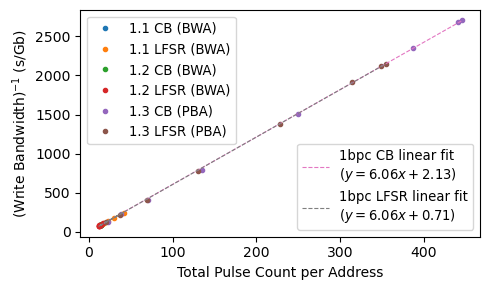

2, cb, y = 3.01x - 0.23, 0.999343330508642
2, lfsr, y = 3.02x - 8.30, 0.9995988066954509


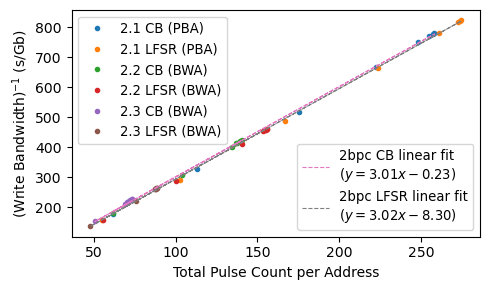

In [7]:
# Plot bandwidth vs. pulse count to show correlation
for bpc in range(1, 3):
  plt.figure(figsize=(5,3))
  for (bpc, alias), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "name"]):
    plt.xlabel("Total Pulse Count per Address")
    plt.ylabel("(Write Bandwidth)$^{-1}$ (s/Gb)")
    # plt.plot(1e6/d["bw"], 1e9*d["energy_per_bit"], ".", label=alias)
    plt.plot((d["sets"] + d["resets"])/d["successes"], 1e9/d["bw"], ".", label=alias)
    # plt.plot((d["sets"] + d["resets"])/d["successes"], d["energy_per_bit"], ".", label=alias)

  fitlines, fitlinelabels = [], []
  for (bpc, mode), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "mode"]):
    X = ((d["sets"] + d["resets"])/d["successes"]).values.reshape(-1,1)
    y = 1e9/d["bw"].values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    R2 = lr.score(X, y)
    eqn = f"y = {lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}".replace("+ -", "- ")
    print(bpc, mode, eqn, R2, sep=", ")
    fitline, = plt.plot(X, lr.predict(X), "--", linewidth=0.8)
    fitlines.append(fitline)
    fitlinelabels.append(f"{bpc}bpc {mode.upper()} linear fit\n(${eqn}$)")
  # plt.xscale("log")
  # plt.yscale("log")
  leg1 = plt.legend(fitlines, fitlinelabels, fontsize=9.5, ncols=1, loc="lower right")
  plt.gca().add_artist(leg1)
  plt.legend(fontsize=9.5, ncols=1, loc="upper left")
  plt.tight_layout()
  plt.savefig(f"../analysis/figs/{bpc}bpc_bw_vs_pulses.pdf")
  plt.show()

1, cb, y = 27.77x + 84.04, 0.9999783415105288
1, lfsr, y = 27.91x + 41.37, 0.9999308161156161


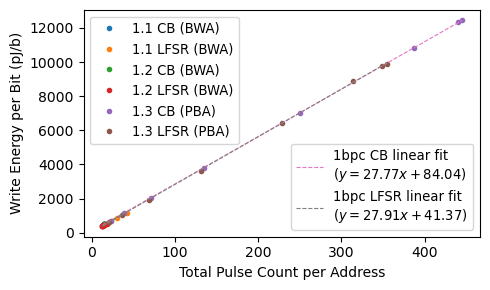

2, cb, y = 13.73x + 59.05, 0.9998745312140723
2, lfsr, y = 13.78x - 15.43, 0.9998199760780425


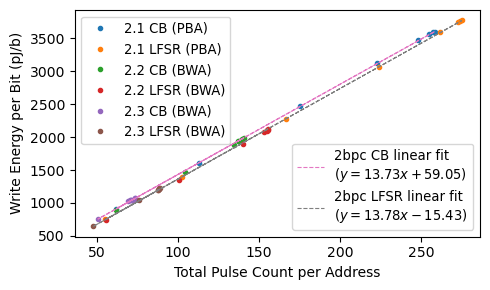

In [8]:
# Plot write energy vs. pulse count to show correlation
for bpc in range(1, 3):
  plt.figure(figsize=(5,3))
  for (bpc, alias), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "name"]):
    plt.xlabel("Total Pulse Count per Address")
    plt.ylabel("Write Energy per Bit (pJ/b)")
    # plt.plot(1e6/d["bw"], 1e9*d["energy_per_bit"], ".", label=alias)
    # plt.plot((d["sets"] + d["resets"])/d["successes"], 1e9/d["bw"], ".", label=alias)
    plt.plot((d["sets"] + d["resets"])/d["successes"], 1e12*d["energy_per_bit"], ".", label=alias)

  fitlines, fitlinelabels = [], []
  for (bpc, mode), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "mode"]):
    X = ((d["sets"] + d["resets"])/d["successes"]).values.reshape(-1,1)
    y = 1e12*d["energy_per_bit"].values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    R2 = lr.score(X, y)
    eqn = f"y = {lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}".replace("+ -", "- ")
    print(bpc, mode, eqn, R2, sep=", ")
    fitline, = plt.plot(X, lr.predict(X), "--", linewidth=0.8)
    fitlines.append(fitline)
    fitlinelabels.append(f"{bpc}bpc {mode.upper()} linear fit\n(${eqn}$)")
  # plt.xscale("log")
  # plt.yscale("log")
  leg1 = plt.legend(fitlines, fitlinelabels, fontsize=9.5, ncols=1, loc="lower right")
  plt.gca().add_artist(leg1)
  plt.legend(fontsize=9.5, ncols=1, loc="upper left")
  plt.tight_layout()
  plt.savefig(f"../analysis/figs/{bpc}bpc_energy_vs_pulses.pdf")
  plt.show()

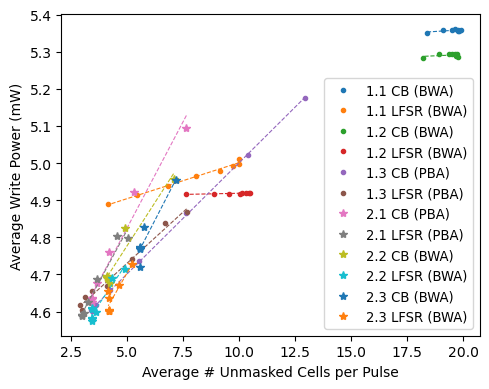

In [9]:
# Plot write power vs. unmasked cell count to show correlation
plt.figure(figsize=(5,4))
for bpc in range(1, 3):
  for (bpc, alias), d in data[(data["bpc"] == bpc) & (data["att"] >= 16) & (data["att"] <= 2048)].groupby(["bpc", "name"]):
    plt.xlabel("Average # Unmasked Cells per Pulse")
    plt.ylabel("Average Write Power (mW)")
    # plt.plot(1e6/d["bw"], 1e9*d["energy_per_bit"], ".", label=alias)
    # plt.plot((d["sets"] + d["resets"])/d["successes"], 1e9/d["bw"], ".", label=alias)
    color = plt.plot((d["set_bits"] + d["reset_bits"])/(d["sets"] + d["resets"]), 1e3*d["power_tot"], "." if bpc == 1 else "*", label=alias)[0].get_color()
    
    X = ((d["set_bits"] + d["reset_bits"])/(d["sets"] + d["resets"])).values.reshape(-1,1)
    y = 1e3*d["power_tot"].values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    R2 = lr.score(X, y)
    eqn = f"y = {lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}".replace("+ -", "- ")
    # print(bpc, mode, eqn, R2, sep=", ")
    fitline, = plt.plot(X, lr.predict(X), "--", color=color, linewidth=0.8)
    fitlines.append(fitline)
    fitlinelabels.append(f"{bpc}bpc {mode.upper()} linear fit\n(${eqn}$)")
  # plt.xscale("log")
  # plt.yscale("log")
  # leg1 = plt.legend(fitlines, fitlinelabels, fontsize=9.5, ncols=1, loc="lower right")
# plt.gca().add_artist(leg1)
plt.legend(fontsize=9.5, ncols=1, loc="lower right")
plt.tight_layout()
plt.savefig("../analysis/figs/write_power_corr.pdf")
plt.show()